# Chapter 2 - Financial Data Structures

### Exercise 2.1
**Note:** Adapted for BTCUSDT and initially used over a 3 month dataset, will later update for a 12 month dataset

Let's start by importing a sample of the raw predownloaded BTC data into the notebook

In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
from pathlib import Path

# Cell 2: Load one file to inspect
data_dir = Path('../binance_raw_data/BTCUSDT')
sample_file = data_dir / '2025-07-09.parquet'

df = pd.read_parquet(sample_file)

# Cell 3: Basic inspection
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)

Shape: (626949, 6)

Columns: ['timestamp', 'symbol', 'price', 'quantity', 'dollar_volume', 'is_buyer_maker']

First few rows:
                timestamp   symbol      price  quantity  dollar_volume  \
0 2025-07-08 16:00:00.029  BTCUSDT  108268.35   0.00434     469.884639   
1 2025-07-08 16:00:00.187  BTCUSDT  108268.34   0.00058      62.795637   
2 2025-07-08 16:00:00.250  BTCUSDT  108268.35   0.00012      12.992202   
3 2025-07-08 16:00:00.402  BTCUSDT  108268.35   0.00021      22.736354   
4 2025-07-08 16:00:00.517  BTCUSDT  108268.34   0.00180     194.883012   

   is_buyer_maker  
0           False  
1            True  
2           False  
3           False  
4            True  

Data types:
timestamp         datetime64[ns]
symbol                    object
price                    float64
quantity                 float64
dollar_volume            float64
is_buyer_maker              bool
dtype: object


Now lets import the entire series of data

In [2]:
# Load all parquet files
all_files = sorted(data_dir.glob('*.parquet'))
print(f"Found {len(all_files)} files")

# Concatenate all files
df_all = pd.concat([pd.read_parquet(f) for f in all_files], ignore_index=True)

print(f"\nTotal ticks: {len(df_all):,}")
print(f"Date range: {df_all['timestamp'].min()} to {df_all['timestamp'].max()}")
print(f"Memory usage: {df_all.memory_usage(deep=True).sum() / 1e6:.2f} MB")

Found 94 files

Total ticks: 74,682,993
Date range: 2025-07-08 16:00:00.029000 to 2025-10-10 15:59:59.995000
Memory usage: 6646.79 MB


### 2.1 On a series of BTCUSDT tick data...

(2.1a) Form tick, volume, and dollar bars.

In [13]:
# Optimised Tick Bars
def form_tick_bars_fast(df, tick_threshold):
    """
    Vectorised tick bar formation - slices instead of row-by-row
    """
    n_bars = len(df) // tick_threshold
    
    # Pre-allocate arrays for speed
    timestamps = np.empty(n_bars, dtype='datetime64[ns]')
    opens = np.empty(n_bars)
    highs = np.empty(n_bars)
    lows = np.empty(n_bars)
    closes = np.empty(n_bars)
    volumes = np.empty(n_bars)
    dollar_volumes = np.empty(n_bars)
    
    prices = df['price'].values
    quantities = df['quantity'].values
    dollars = df['dollar_volume'].values
    times = df['timestamp'].values
    
    for i in range(n_bars):
        start_idx = i * tick_threshold
        end_idx = start_idx + tick_threshold
        
        timestamps[i] = times[end_idx - 1]
        opens[i] = prices[start_idx]
        highs[i] = prices[start_idx:end_idx].max()
        lows[i] = prices[start_idx:end_idx].min()
        closes[i] = prices[end_idx - 1]
        volumes[i] = quantities[start_idx:end_idx].sum()
        dollar_volumes[i] = dollars[start_idx:end_idx].sum()
    
    return pd.DataFrame({
        'timestamp': timestamps,
        'open': opens,
        'high': highs,
        'low': lows,
        'close': closes,
        'volume': volumes,
        'dollar_volume': dollar_volumes,
        'num_ticks': tick_threshold
    })

# # Tick Bar Function
# def form_tick_bars(df, tick_threshold):
#     """
#     Form tick bars - sample every N ticks
    
#     Parameters:
#     -----------
#     df : pd.DataFrame
#         Tick data with columns: timestamp, price, quantity, dollar_volume
#     tick_threshold : int
#         Number of ticks per bar
    
#     Returns:
#     --------
#     pd.DataFrame with OHLC bars
#     """
#     bars = []
    
#     for i in range(0, len(df), tick_threshold):
#         # Get chunk of ticks
#         chunk = df.iloc[i:i+tick_threshold]
        
#         if len(chunk) == 0:
#             continue
            
#         bar = {
#             'timestamp': chunk['timestamp'].iloc[-1],  # Close time
#             'open': chunk['price'].iloc[0],
#             'high': chunk['price'].max(),
#             'low': chunk['price'].min(),
#             'close': chunk['price'].iloc[-1],
#             'volume': chunk['quantity'].sum(),
#             'dollar_volume': chunk['dollar_volume'].sum(),
#             'num_ticks': len(chunk)
#         }
#         bars.append(bar)
    
#     return pd.DataFrame(bars)

In [14]:
# Optimised Volume Bars
def form_volume_bars_fast(df, volume_threshold):
    """
    Vectorised volume bar formation using cumsum + searchsorted
    """
    # Cumulative volume
    cumsum_volume = df['quantity'].cumsum().values
    
    # Find bar boundaries efficiently
    thresholds = np.arange(volume_threshold, cumsum_volume[-1], volume_threshold)
    bar_indices = np.searchsorted(cumsum_volume, thresholds)
    bar_indices = np.insert(bar_indices, 0, 0)
    
    # Extract values as numpy arrays for speed
    prices = df['price'].values
    quantities = df['quantity'].values
    dollars = df['dollar_volume'].values
    times = df['timestamp'].values
    
    # Pre-allocate
    n_bars = len(bar_indices) - 1
    timestamps = np.empty(n_bars, dtype='datetime64[ns]')
    opens = np.empty(n_bars)
    highs = np.empty(n_bars)
    lows = np.empty(n_bars)
    closes = np.empty(n_bars)
    volumes = np.empty(n_bars)
    dollar_volumes = np.empty(n_bars)
    num_ticks = np.empty(n_bars, dtype=int)
    
    for i in range(n_bars):
        start = bar_indices[i]
        end = bar_indices[i + 1]
        
        timestamps[i] = times[end - 1]
        opens[i] = prices[start]
        highs[i] = prices[start:end].max()
        lows[i] = prices[start:end].min()
        closes[i] = prices[end - 1]
        volumes[i] = quantities[start:end].sum()
        dollar_volumes[i] = dollars[start:end].sum()
        num_ticks[i] = end - start
    
    return pd.DataFrame({
        'timestamp': timestamps,
        'open': opens,
        'high': highs,
        'low': lows,
        'close': closes,
        'volume': volumes,
        'dollar_volume': dollar_volumes,
        'num_ticks': num_ticks
    })


# # Volume Bar Function
# def form_volume_bars(df, volume_threshold):
#     """
#     Form volume bars - sample every N units of volume (BTC)
    
#     Parameters:
#     -----------
#     df : pd.DataFrame
#         Tick data with columns: timestamp, price, quantity, dollar_volume
#     volume_threshold : float
#         Volume in BTC per bar
    
#     Returns:
#     --------
#     pd.DataFrame with OHLC bars
#     """
#     bars = []
#     cumulative_volume = 0
#     bar_start_idx = 0
    
#     for i in range(len(df)):
#         cumulative_volume += df.iloc[i]['quantity']
        
#         # When threshold reached, close the bar
#         if cumulative_volume >= volume_threshold:
#             chunk = df.iloc[bar_start_idx:i+1]
            
#             bar = {
#                 'timestamp': chunk['timestamp'].iloc[-1],
#                 'open': chunk['price'].iloc[0],
#                 'high': chunk['price'].max(),
#                 'low': chunk['price'].min(),
#                 'close': chunk['price'].iloc[-1],
#                 'volume': chunk['quantity'].sum(),
#                 'dollar_volume': chunk['dollar_volume'].sum(),
#                 'num_ticks': len(chunk)
#             }
#             bars.append(bar)
            
#             # Reset for next bar
#             cumulative_volume = 0
#             bar_start_idx = i + 1
    
#     return pd.DataFrame(bars)

In [15]:
# Optimised Dollar Bars
def form_dollar_bars_fast(df, dollar_threshold):
    """
    Vectorised dollar bar formation using cumsum + searchsorted
    """
    # Cumulative dollar volume
    cumsum_dollars = df['dollar_volume'].cumsum().values
    
    # Find bar boundaries efficiently
    thresholds = np.arange(dollar_threshold, cumsum_dollars[-1], dollar_threshold)
    bar_indices = np.searchsorted(cumsum_dollars, thresholds)
    bar_indices = np.insert(bar_indices, 0, 0)
    
    # Extract values as numpy arrays
    prices = df['price'].values
    quantities = df['quantity'].values
    dollars = df['dollar_volume'].values
    times = df['timestamp'].values
    
    # Pre-allocate
    n_bars = len(bar_indices) - 1
    timestamps = np.empty(n_bars, dtype='datetime64[ns]')
    opens = np.empty(n_bars)
    highs = np.empty(n_bars)
    lows = np.empty(n_bars)
    closes = np.empty(n_bars)
    volumes = np.empty(n_bars)
    dollar_volumes = np.empty(n_bars)
    num_ticks = np.empty(n_bars, dtype=int)
    
    for i in range(n_bars):
        start = bar_indices[i]
        end = bar_indices[i + 1]
        
        timestamps[i] = times[end - 1]
        opens[i] = prices[start]
        highs[i] = prices[start:end].max()
        lows[i] = prices[start:end].min()
        closes[i] = prices[end - 1]
        volumes[i] = quantities[start:end].sum()
        dollar_volumes[i] = dollars[start:end].sum()
        num_ticks[i] = end - start
    
    return pd.DataFrame({
        'timestamp': timestamps,
        'open': opens,
        'high': highs,
        'low': lows,
        'close': closes,
        'volume': volumes,
        'dollar_volume': dollar_volumes,
        'num_ticks': num_ticks
    })

# # Dollar Bar Function
# def form_dollar_bars(df, dollar_threshold):
#     """
#     Form dollar bars - sample every N dollars exchanged
    
#     Parameters:
#     -----------
#     df : pd.DataFrame
#         Tick data with columns: timestamp, price, quantity, dollar_volume
#     dollar_threshold : float
#         Dollar volume in USDT per bar
    
#     Returns:
#     --------
#     pd.DataFrame with OHLC bars
#     """
#     bars = []
#     cumulative_dollars = 0
#     bar_start_idx = 0
    
#     for i in range(len(df)):
#         cumulative_dollars += df.iloc[i]['dollar_volume']
        
#         # When threshold reached, close the bar
#         if cumulative_dollars >= dollar_threshold:
#             chunk = df.iloc[bar_start_idx:i+1]
            
#             bar = {
#                 'timestamp': chunk['timestamp'].iloc[-1],
#                 'open': chunk['price'].iloc[0],
#                 'high': chunk['price'].max(),
#                 'low': chunk['price'].min(),
#                 'close': chunk['price'].iloc[-1],
#                 'volume': chunk['quantity'].sum(),
#                 'dollar_volume': chunk['dollar_volume'].sum(),
#                 'num_ticks': len(chunk)
#             }
#             bars.append(bar)
            
#             # Reset for next bar
#             cumulative_dollars = 0
#             bar_start_idx = i + 1
    
#     return pd.DataFrame(bars)

a quick test (before loading all data)

In [16]:
# Test on small sample first
print("Testing optimized functions on 1M ticks...")
test_sample = df_all.head(1_000_000)

start = time.time()
tick_bars_test = form_tick_bars_fast(test_sample, tick_threshold=14_936)
print(f"Tick bars: {len(tick_bars_test)} bars in {time.time()-start:.2f}s")

start = time.time()
volume_bars_test = form_volume_bars_fast(test_sample, volume_threshold=285.42)
print(f"Volume bars: {len(volume_bars_test)} bars in {time.time()-start:.2f}s")

start = time.time()
dollar_bars_test = form_dollar_bars_fast(test_sample, dollar_threshold=33_111_838)
print(f"Dollar bars: {len(dollar_bars_test)} bars in {time.time()-start:.2f}s")

Testing optimized functions on 1M ticks...
Tick bars: 66 bars in 0.00s
Volume bars: 65 bars in 0.01s
Dollar bars: 62 bars in 0.01s


In [7]:
# Form all three bar types

# Choose thresholds (we will later tune these values based on initial data)

print("Forming tick bars...")
tick_bars = form_tick_bars(df_all, tick_threshold=1000)
print(f"✓ Tick bars: {len(tick_bars):,} bars\n")

print("Forming volume bars...")
volume_bars = form_volume_bars(df_all, volume_threshold=10.0)
print(f"✓ Volume bars: {len(volume_bars):,} bars\n")

print("Forming dollar bars...")
dollar_bars = form_dollar_bars(df_all, dollar_threshold=1_000_000)
print(f"✓ Dollar bars: {len(dollar_bars):,} bars")

Forming tick bars...
✓ Tick bars: 74,683 bars

Forming volume bars...
✓ Volume bars: 135,681 bars

Forming dollar bars...
✓ Dollar bars: 156,250 bars


In [8]:
# Inspect the results
print("=" * 60)
print("TICK BARS")
print("=" * 60)
print(tick_bars.head())
print(f"\nShape: {tick_bars.shape}")

print("\n" + "=" * 60)
print("VOLUME BARS")
print("=" * 60)
print(volume_bars.head())
print(f"\nShape: {volume_bars.shape}")

print("\n" + "=" * 60)
print("DOLLAR BARS")
print("=" * 60)
print(dollar_bars.head())
print(f"\nShape: {dollar_bars.shape}")

TICK BARS
                timestamp       open       high        low      close  \
0 2025-07-08 16:01:55.910  108268.35  108302.14  108264.28  108302.14   
1 2025-07-08 16:03:58.060  108302.13  108346.28  108302.13  108315.39   
2 2025-07-08 16:05:56.992  108315.38  108332.00  108266.77  108266.77   
3 2025-07-08 16:07:26.809  108266.77  108293.17  108238.00  108263.53   
4 2025-07-08 16:09:00.753  108260.00  108260.00  108206.71  108219.50   

     volume  dollar_volume  num_ticks  
0   6.45962   6.994695e+05       1000  
1   7.32687   7.936291e+05       1000  
2  10.24668   1.109864e+06       1000  
3   3.58194   3.878065e+05       1000  
4   8.11714   8.784549e+05       1000  

Shape: (74683, 8)

VOLUME BARS
                timestamp       open       high        low      close  \
0 2025-07-08 16:02:40.622  108268.35  108346.28  108264.28  108337.50   
1 2025-07-08 16:04:57.883  108337.50  108337.51  108302.17  108327.59   
2 2025-07-08 16:07:47.659  108327.58  108327.58  108221.25  

now lets optimise threshold values for BTC

In [9]:
# Quick statistics to guide threshold selection
print("DATA STATISTICS FOR THRESHOLD SELECTION")
print("=" * 60)

total_ticks = len(df_all)
total_volume_btc = df_all['quantity'].sum()
total_dollar_volume = df_all['dollar_volume'].sum()
num_days = (df_all['timestamp'].max() - df_all['timestamp'].min()).days

print(f"Total ticks: {total_ticks:,}")
print(f"Total volume: {total_volume_btc:,.2f} BTC")
print(f"Total dollar volume: ${total_dollar_volume:,.0f}")
print(f"Number of days: {num_days}")
print(f"\nDaily averages:")
print(f"  Ticks per day: {total_ticks/num_days:,.0f}")
print(f"  Volume per day: {total_volume_btc/num_days:,.2f} BTC")
print(f"  Dollar volume per day: ${total_dollar_volume/num_days:,.0f}")

# Target: ~5000 bars over 3 months for good statistics
target_bars = 5000

print(f"\n{'='*60}")
print(f"RECOMMENDED THRESHOLDS (for ~{target_bars:,} bars total)")
print(f"{'='*60}")
print(f"Tick threshold: {int(total_ticks / target_bars):,} ticks per bar")
print(f"Volume threshold: {total_volume_btc / target_bars:.2f} BTC per bar")
print(f"Dollar threshold: ${total_dollar_volume / target_bars:,.0f} per bar")

DATA STATISTICS FOR THRESHOLD SELECTION
Total ticks: 74,682,993
Total volume: 1,427,122.33 BTC
Total dollar volume: $165,559,188,886
Number of days: 93

Daily averages:
  Ticks per day: 803,043
  Volume per day: 15,345.40 BTC
  Dollar volume per day: $1,780,206,332

RECOMMENDED THRESHOLDS (for ~5,000 bars total)
Tick threshold: 14,936 ticks per bar
Volume threshold: 285.42 BTC per bar
Dollar threshold: $33,111,838 per bar


update the optimised threshold values and run again

In [17]:
# If test looks good, run on full dataset
print("\n" + "="*60)
print("Running on FULL dataset (74M ticks)...")
print("="*60)

start = time.time()
tick_bars = form_tick_bars_fast(df_all, tick_threshold=14_936)
tick_time = time.time() - start
print(f"✓ Tick bars: {len(tick_bars):,} bars in {tick_time:.1f}s")

start = time.time()
volume_bars = form_volume_bars_fast(df_all, volume_threshold=285.42)
vol_time = time.time() - start
print(f"✓ Volume bars: {len(volume_bars):,} bars in {vol_time:.1f}s")

start = time.time()
dollar_bars = form_dollar_bars_fast(df_all, dollar_threshold=33_111_838)
dollar_time = time.time() - start
print(f"✓ Dollar bars: {len(dollar_bars):,} bars in {dollar_time:.1f}s")

print(f"\nTotal time: {tick_time + vol_time + dollar_time:.1f}s")


Running on FULL dataset (74M ticks)...
✓ Tick bars: 5,000 bars in 0.1s
✓ Volume bars: 5,000 bars in 0.4s
✓ Dollar bars: 4,999 bars in 0.4s

Total time: 0.9s


(2.1b) Count the number of bars produced by tick, volume, and dollar bars on a weekly basis. Plot a time series of that bar count. What bar type produces the most stable weekly count? Why?

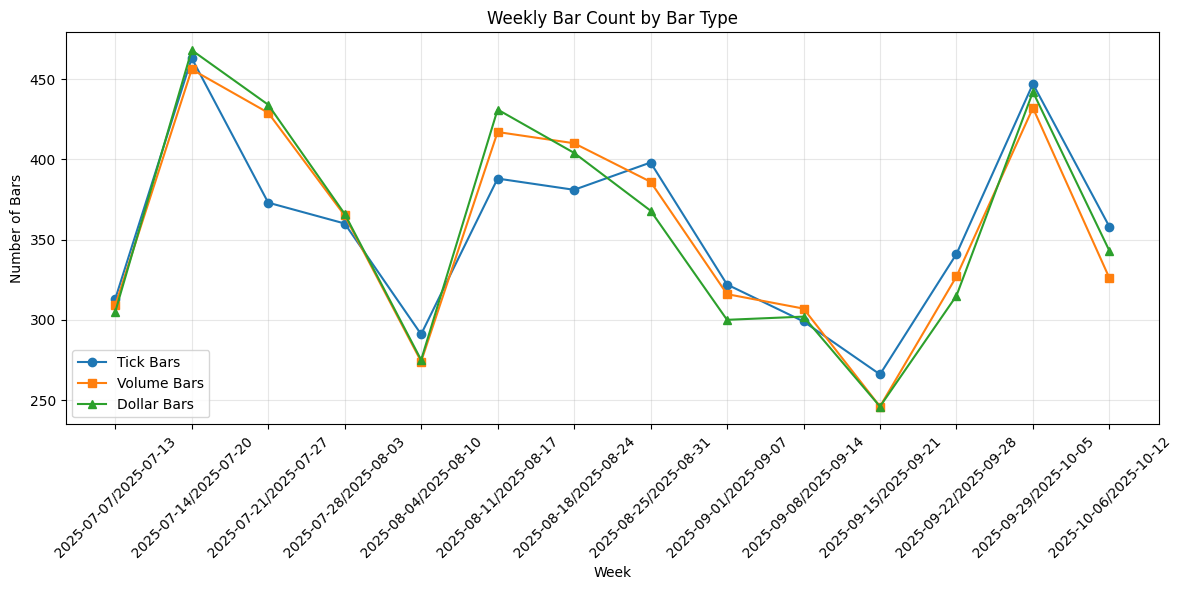

Standard Deviation of Weekly Counts:
Tick bars: 57.00
Volume bars: 65.33
Dollar bars: 69.80


In [19]:
# Exercise 2.1(b): Count bars per week and plot

import matplotlib.pyplot as plt

# Add week column to each bar type
tick_bars['week'] = tick_bars['timestamp'].dt.to_period('W')
volume_bars['week'] = volume_bars['timestamp'].dt.to_period('W')
dollar_bars['week'] = dollar_bars['timestamp'].dt.to_period('W')

# Count bars per week
tick_weekly = tick_bars.groupby('week').size()
volume_weekly = volume_bars.groupby('week').size()
dollar_weekly = dollar_bars.groupby('week').size()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(tick_weekly.index.astype(str), tick_weekly.values, marker='o', label='Tick Bars')
plt.plot(volume_weekly.index.astype(str), volume_weekly.values, marker='s', label='Volume Bars')
plt.plot(dollar_weekly.index.astype(str), dollar_weekly.values, marker='^', label='Dollar Bars')

plt.xlabel('Week')
plt.ylabel('Number of Bars')
plt.title('Weekly Bar Count by Bar Type')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Which is most stable? (lowest standard deviation)
print("Standard Deviation of Weekly Counts:")
print(f"Tick bars: {tick_weekly.std():.2f}")
print(f"Volume bars: {volume_weekly.std():.2f}")
print(f"Dollar bars: {dollar_weekly.std():.2f}")

(c) Compute the serial correlation of returns for the three bar types. What bar method has the lowest serial correlation?

(d) Partition the bar series into monthly subsets. Compute the variance of returns for every subset of every bar type. Compute the variance of those variances. What method exhibits the smallest variance of variances?

(e) Apply the Jarque-Bera normality test on returns from the three bar types. What method achieves the lowest test statistic?